In [45]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
from torch.optim import lr_scheduler

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import random
from imutils import paths
import os
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import time
import datetime
import copy
from Custom import Custom

In [46]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [47]:
class CDDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_paths = df['images']
        self.labels = df['labels']
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(os.path.join("data/dogs-vs-cats/train/train/",self.image_paths[idx]))
        img = img.resize((128,128))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [48]:
image_paths = list(paths.list_images("./data/dogs-vs-cats/train/train"))
print(len(image_paths))
random.shuffle(image_paths)
names = []
labels = []
for i in tqdm(image_paths):
    name = Path(i).name
    label = name.split(".")[0]
    if label == "cat":
        label = 0
    if label == "dog":
        label = 1
    labels.append(label)
    names.append(name)
train =  pd.DataFrame({"images":pd.Series(names[:23000]),"labels":pd.Series(labels[:23000])})
val = pd.DataFrame({"images":pd.Series(names[23000:]),"labels":pd.Series(labels[23000:])})
del names,image_paths, labels

25000


In [49]:
image_datasets = {}
batch_size = 4
image_datasets['train'] = CDDataset(train,data_transforms['train'])
image_datasets['val'] = CDDataset(val,data_transforms['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ["cat", "dog"]
print(dataset_sizes, class_names)

{'train': 23000, 'val': 2000} ['cat', 'dog']


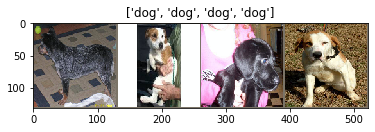

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 100)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(datetime.datetime.now(),"\n")
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            count = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                count = count +1 
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

                if count%100 == 0:
                    print("-"*40)
                    print("STEP : ",count,"/",len(dataloaders[phase]))
                    print('ACC : {:.4f}'.format(running_corrects.double()/(count*batch_size)), phase.upper(),"LOSS: {:.4f}".format(running_loss / count))
#                     if phase == "train": writer.add_scalar('training loss',running_loss / count , epoch * len(train_dataloader) + count)
#                     if phase == "train": writer.add_scalar('training Accuracy',running_corrects.double() / (count*batch_size) , epoch * len(train_dataloader) + count)
#                     if phase == "test": writer.add_scalar('testing loss',running_loss / count , epoch * len(test_dataloader) + count)
#                     if phase == "test": writer.add_scalar('testing Accuracy',running_corrects.double() / (count*batch_size) , epoch * len(test_dataloader) + count)
#                     if phase == "train": writer.add_histogram("FC1 - Weights",model.fc1.weight.cpu().detach().numpy(),count)
#                     if phase == "train": writer.add_histogram("Conv1 - Weights",model.conv_1.weight.cpu().detach().numpy(),count)
#                     if phase == "train": writer.add_histogram("Conv2 - Weights",model.conv_2.weight.cpu().detach().numpy(),count)
#                     if phase == "train": writer.add_histogram("Conv3 - Weights",model.conv_3.weight.cpu().detach().numpy(),count)
#                     if phase == "train": writer.add_histogram("Conv4 - Weights",model.conv_4.weight.cpu().detach().numpy(),count)
#                     writer.flush()
                    
            if phase == 'train':
                scheduler.step()
                

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("-"*100)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print("-"*100)
    print("-"*100)
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [52]:
custom = False
if custom:
    model_ft = Custom()
    print("Using Custom Model")
else:
    print("Using predefined Model")
    model_ft = torchvision.models.resnet18(pretrained=True)
#     print(model_ft)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = torch.nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.001)
pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
print("Total Model Parameters:",pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print("Total Trainable Parameters",pytorch_trainable_params)

Using predefined Model
Total Model Parameters: 11177538
Total Trainable Parameters 1026


In [53]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------------------------------------------------------------------------------------------------
2020-06-18 21:11:01.933835 

----------------------------------------
STEP :  100 / 5750
ACC : 0.6500 TRAIN LOSS: 0.5985
----------------------------------------
STEP :  200 / 5750
ACC : 0.7125 TRAIN LOSS: 0.5185
----------------------------------------
STEP :  300 / 5750
ACC : 0.7475 TRAIN LOSS: 0.4775
----------------------------------------
STEP :  400 / 5750
ACC : 0.7612 TRAIN LOSS: 0.4557
----------------------------------------
STEP :  500 / 5750
ACC : 0.7635 TRAIN LOSS: 0.4619
----------------------------------------
STEP :  600 / 5750
ACC : 0.7667 TRAIN LOSS: 0.4604
----------------------------------------
STEP :  700 / 5750
ACC : 0.7682 TRAIN LOSS: 0.4732
----------------------------------------
STEP :  800 / 5750
ACC : 0.7725 TRAIN LOSS: 0.4678
----------------------------------------
STEP :  900 / 5750
ACC : 0.7786 TRAIN LOSS: 0.4611
--------------------------------

----------------------------------------
STEP :  2200 / 5750
ACC : 0.8219 TRAIN LOSS: 0.4149
----------------------------------------
STEP :  2300 / 5750
ACC : 0.8197 TRAIN LOSS: 0.4173
----------------------------------------
STEP :  2400 / 5750
ACC : 0.8191 TRAIN LOSS: 0.4174
----------------------------------------
STEP :  2500 / 5750
ACC : 0.8182 TRAIN LOSS: 0.4165
----------------------------------------
STEP :  2600 / 5750
ACC : 0.8170 TRAIN LOSS: 0.4171
----------------------------------------
STEP :  2700 / 5750
ACC : 0.8157 TRAIN LOSS: 0.4192
----------------------------------------
STEP :  2800 / 5750
ACC : 0.8158 TRAIN LOSS: 0.4177
----------------------------------------
STEP :  2900 / 5750
ACC : 0.8166 TRAIN LOSS: 0.4169
----------------------------------------
STEP :  3000 / 5750
ACC : 0.8159 TRAIN LOSS: 0.4168
----------------------------------------
STEP :  3100 / 5750
ACC : 0.8165 TRAIN LOSS: 0.4160
----------------------------------------
STEP :  3200 / 5750
ACC : 0.8

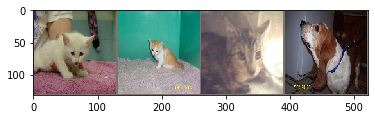

GroundTruth:  tensor(1) tensor(1) tensor(1) tensor(1)
Predicted:  tensor(1) tensor(1) tensor(1) tensor(1)


In [54]:
def imshow(inp, transpose = True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model_ft(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [55]:
ind = 3
input = images[ind].unsqueeze(0)
input.requires_grad = True

In [56]:
def attribute_image_features(algorithm, input, **kwargs):
    model_ft.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs)
    return tensor_attributions

In [57]:
saliency = Saliency(model_ft)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [58]:
ig = IntegratedGradients(model_ft)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1841], dtype=torch.float64)


In [59]:
ig = IntegratedGradients(model_ft)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      n_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1310720000 bytes. Buy new RAM!


In [ ]:
dl = DeepLift(model_ft)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [ ]:
import torch.nn.functional as F
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")